In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import random
import cv2


In [3]:
from PIL import Image
import numpy as np

label_path = '/content/drive/MyDrive/Data/data/labels/0.png'
label = Image.open(label_path)
label_np = np.array(label)

# Check unique pixel values in the label
unique_values = np.unique(label_np)
print("Unique pixel values in label:", unique_values)


Unique pixel values in label: [0 1]


In [4]:
pip install tensorflow-io


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 15.6 MB/s eta 0:00:00


In [5]:
images_path = '/content/drive/MyDrive/Data/data/images'
labels_path = '/content/drive/MyDrive/Data/data/labels'


In [6]:
from tifffile import imread
img = imread('/content/drive/MyDrive/Data/data/images/0.tif')

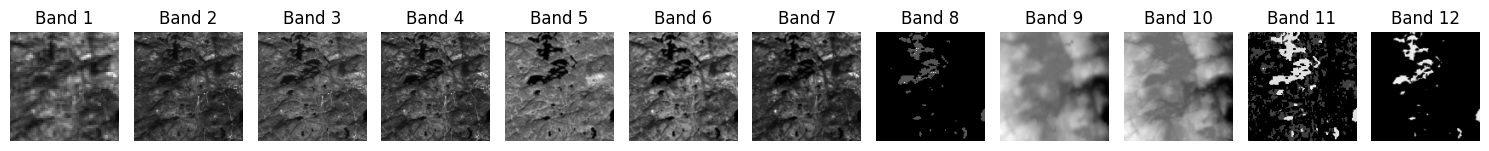

In [7]:
num_bands = img.shape[-1]

fig, axes = plt.subplots(1, num_bands, figsize=(15, 5))

for i in range(num_bands):
    axes[i].imshow(img[:, :, i], cmap='gray')
    axes[i].set_title(f'Band {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [8]:
import os
import tifffile as tiff
import tensorflow as tf
import numpy as np

# Initialize lists to hold images and labels
images = []
labels = []
# Load and preprocess images and labels
for filename in os.listdir(images_path):
    if filename.endswith('.tif'):  # For .tif images
        # Load and preprocess image using tifffile
        image = tiff.imread(os.path.join(images_path, filename))
        image = tf.image.resize(image, [128, 128])
        image = image / 65535.0  # Normalize to [0, 1] (assuming 16-bit images)

        # Load and preprocess corresponding label
        label_filename = filename.replace('.tif', '.png')  # Adjust extension for the label
        label = tf.io.read_file(os.path.join(labels_path, label_filename))
        label = tf.image.decode_png(label, channels=1)  # Decode label as grayscale
        label = tf.image.resize(label, [128, 128])  # Resize to match the image
        label = tf.cast(label, tf.int32)  # Convert label to integer type

        # Append to lists
        images.append(image)
        labels.append(label)

# Convert lists to TensorFlow tensors
images = tf.convert_to_tensor(np.array(images))
labels = tf.convert_to_tensor(np.array(labels))

# Assign each image to its corresponding label in a variable called training_data
training_data = tf.data.Dataset.from_tensor_slices((images, labels))



training_data = tf.data.Dataset.from_tensor_slices((images, labels))


# model

In [9]:

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50

def DeeplabV3Plus(input_shape=(128, 128, 12), num_classes=1):
    """Build DeepLabV3+ architecture from scratch with a custom input shape."""
    inputs = layers.Input(shape=input_shape)

    # Backbone: Use a ResNet50 backbone without pretrained weights and adjusted input channels
    base_model = ResNet50(weights=None, include_top=False, input_tensor=inputs)

    # Atrous Spatial Pyramid Pooling (ASPP)
    # Branch 4 - Global Average Pooling
    b4 = layers.GlobalAveragePooling2D()(base_model.output)  # Shape (None, 2048)
    b4 = layers.Reshape((1, 1, b4.shape[-1]))(b4)  # Shape (None, 1, 1, 2048)
    b4 = layers.Conv2D(256, 1, padding='same', use_bias=False)(b4)  # Shape (None, 1, 1, 256)
    b4 = layers.BatchNormalization()(b4)
    b4 = layers.Activation('relu')(b4)
    b4 = layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(b4)  # Shape (None, 32, 32, 256)
    # b4 = layers.UpSampling2D(size=(32, 32), interpolation='bilinear')(b4)  # Shape (None, 32, 32, 256)

    # Branch 0 - 1x1 Conv
    b0 = layers.Conv2D(256, 1, padding='same', use_bias=False)(base_model.output)  # Shape (None, 32, 32, 256)
    b0 = layers.BatchNormalization()(b0)
    b0 = layers.Activation('relu')(b0)

    # Branch 1 - 3x3 Conv with dilation rate 6
    b1 = layers.Conv2D(256, 3, padding='same', dilation_rate=6, use_bias=False)(base_model.output)  # Shape (None, 32, 32, 256)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.Activation('relu')(b1)

    # Branch 2 - 3x3 Conv with dilation rate 12
    b2 = layers.Conv2D(256, 3, padding='same', dilation_rate=12, use_bias=False)(base_model.output)  # Shape (None, 32, 32, 256)
    b2 = layers.BatchNormalization()(b2)
    b2 = layers.Activation('relu')(b2)

    # Branch 3 - 3x3 Conv with dilation rate 18
    b3 = layers.Conv2D(256, 3, padding='same', dilation_rate=18, use_bias=False)(base_model.output)  # Shape (None, 32, 32, 256)
    b3 = layers.BatchNormalization()(b3)
    b3 = layers.Activation('relu')(b3)

    # Concatenate ASPP branch outputs - All inputs are (32, 32, 256) now
    x = layers.Concatenate()([b4, b0, b1, b2, b3])  # Shape (None, 32, 32, 1280)

    # Convolution after concatenation
    x = layers.Conv2D(256, 1, padding='same', use_bias=False)(x)  # Shape (None, 32, 32, 256)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Upsample to match input size (128x128)
    x = layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(x)  # Shape (None, 128, 128, 256)

    # Decoder: refine segmentation details
    x = layers.Conv2D(256, 3, padding='same', use_bias=False)(x)  # Shape (None, 128, 128, 256)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Final output layer
    x = layers.Conv2D(num_classes, 1, padding='same', activation='sigmoid')(x)  #
    x = layers.UpSampling2D(size=(8, 8), interpolation='bilinear')(x)  # Shape (None, 128, 128, num_classes)
    # Create model
    model = Model(inputs=inputs, outputs=x)

    return model



In [10]:
# Create the model
deeplabv3_plus_model = DeeplabV3Plus(input_shape=(128, 128, 12), num_classes=1)

# Compile the model
deeplabv3_plus_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary
deeplabv3_plus_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 12)   │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 12)   │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │         37,696 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 39,745,217 (151.62 MB)

 Trainable params: 39,688,513 (151.40 MB)

 Non-trainable params: 56,704 (221.50 KB)

In [11]:
def split_dataset(dataset, train_split=0.8, val_split=0.1, test_split=0.1):
    assert train_split + val_split + test_split == 1

    dataset_size = len(dataset)
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size + val_size)

    return train_dataset, val_dataset, test_dataset

train_data, val_data, test_data = split_dataset(training_data)


In [12]:
# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=7, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-5, verbose=1),
]

In [13]:
model_history = deeplabv3_plus_model.fit(
                            train_data.batch(32),
                            validation_data=val_data.batch(32),
                            epochs=30,
                            callbacks=callbacks
                            )


Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 243s 14s/step - accuracy: 0.5883 - loss: 0.9440 - val_accuracy: 0.7604 - val_loss: 0.6193 - learning_rate: 0.0010
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 60s 417ms/step - accuracy: 0.8401 - loss: 0.4380 - val_accuracy: 0.7604 - val_loss: 0.5520 - learning_rate: 0.0010
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 404ms/step - accuracy: 0.8655 - loss: 0.3559 - val_accuracy: 0.7604 - val_loss: 0.5936 - learning_rate: 0.0010
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 403ms/step - accuracy: 0.8738 - loss: 0.3087 - val_accuracy: 0.7604 - val_loss: 0.6422 - learning_rate: 0.0010
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 410ms/step - accuracy: 0.8848 - loss: 0.2846 - val_accuracy: 0.7604 - val_loss: 0.6997 - learning_rate: 0.0010
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 408ms/step - accuracy: 0.8883 - loss: 0.2693 - val_accuracy: 0.7604 - val_loss: 0.9022 - learning_rate: 0.0010
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.8944 - loss: 0.2543
Epoch 7: Reduce

In [15]:
deeplabv3_plus_model.evaluate(test_data.batch(32))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7595 - loss: 0.9492


[0.9491731524467468, 0.75946044921875]

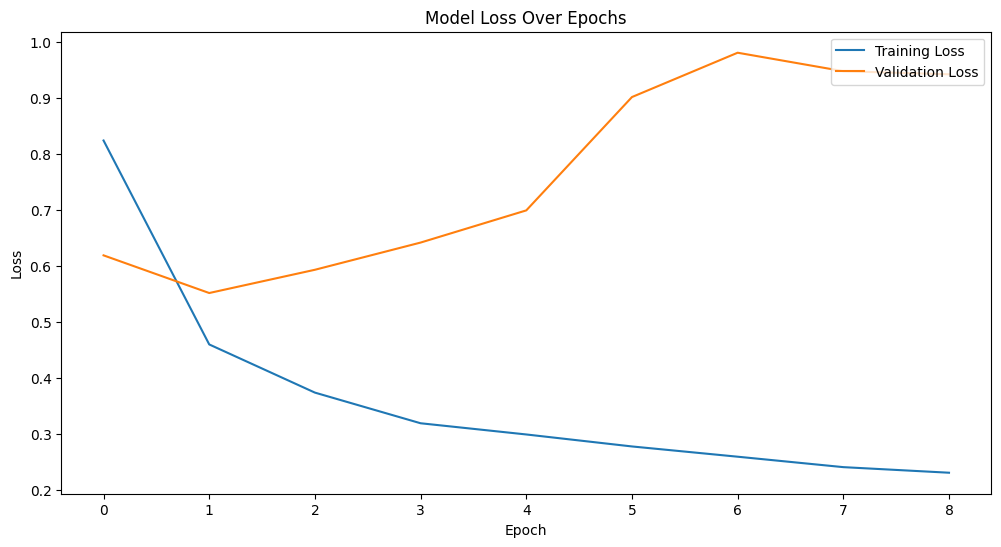

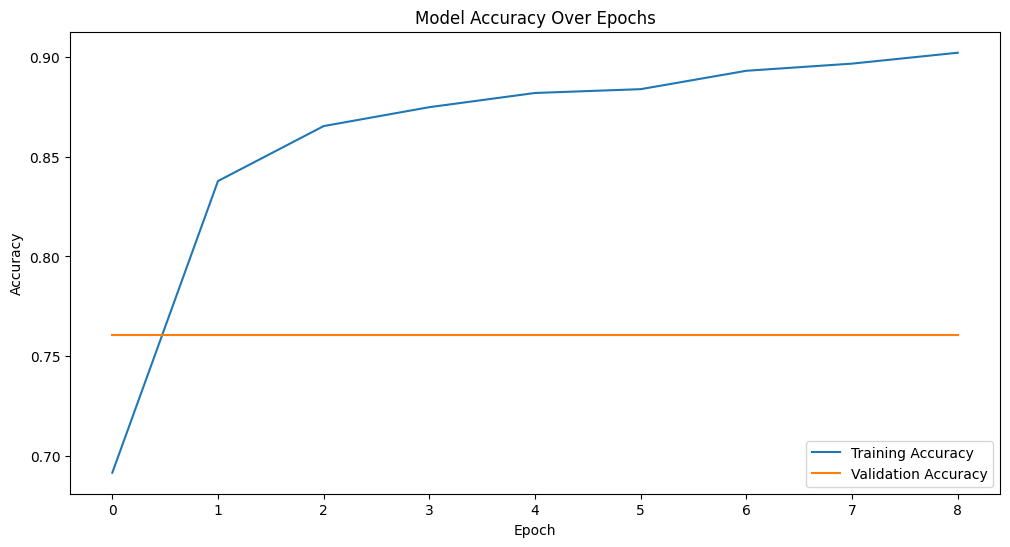

In [16]:
#plot accuracy and loss
  # Plot loss for both phases
plt.figure(figsize=(12, 6))
plt.plot(model_history.history['loss'] , label='Training Loss')
plt.plot(model_history.history['val_loss'] , label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plot accuracy for both phases
plt.figure(figsize=(12, 6))
plt.plot(model_history.history['accuracy'] , label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'] , label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


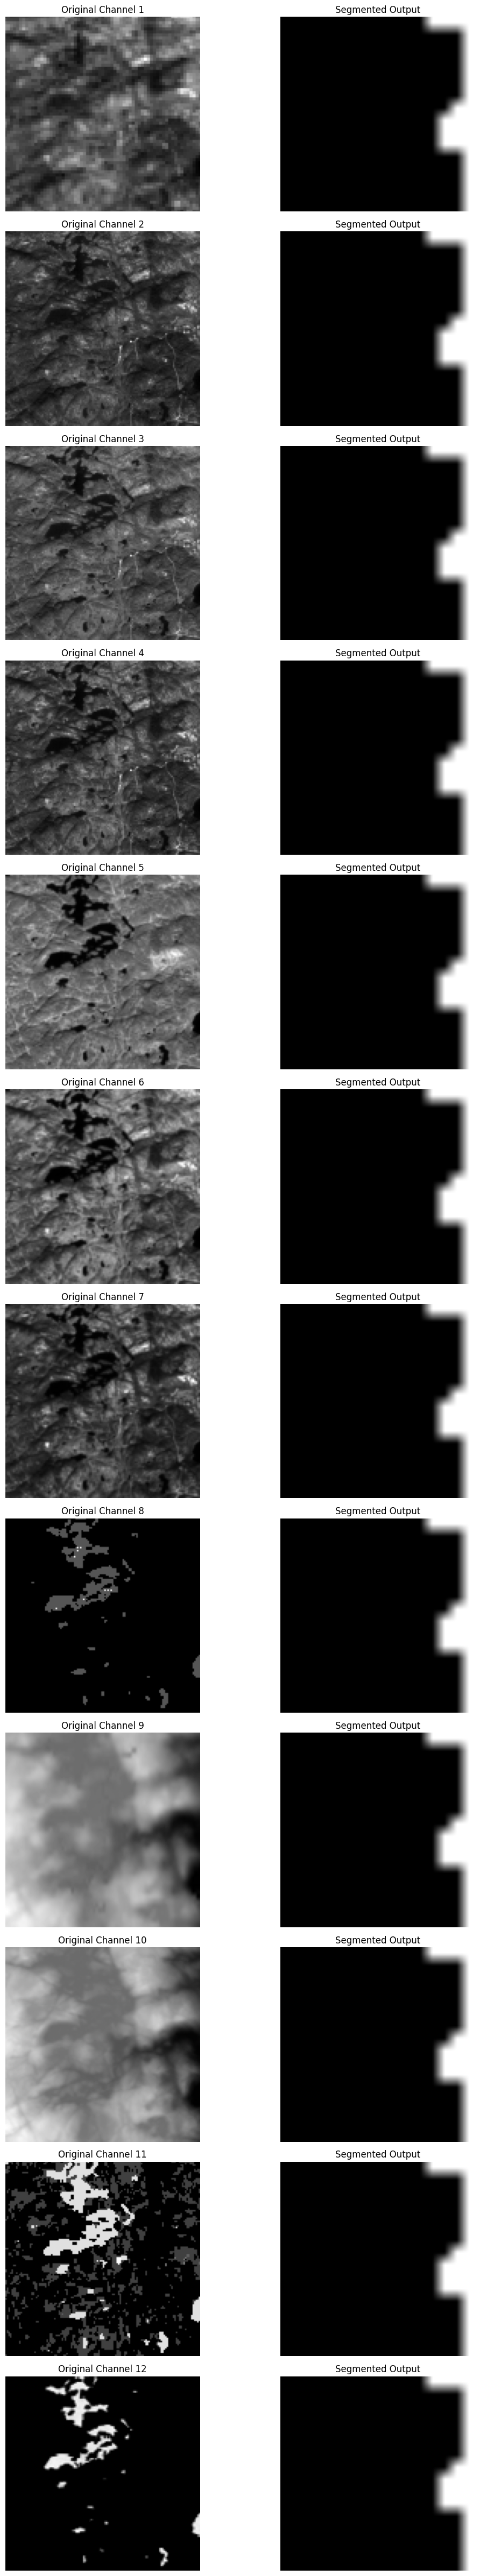

In [18]:
# Load a sample image using tifffile (assuming your images are 128x128 and have 12 channels)
sample_image_path = '/content/drive/MyDrive/Data/data/images/0.tif'
sample_image_array = tiff.imread(sample_image_path)
sample_image_array = sample_image_array.squeeze()  # Remove batch dimension, now shape is (128, 128, 12)

# Predict the segmentation mask using the U-Net model
segmentation_result = deeplabv3_plus_model.predict(sample_image_array.reshape(1, 128, 128, 12))

# Remove the batch dimension from the segmentation result
segmentation_result = segmentation_result.squeeze()  # Shape is now (128, 128)

# Set up a grid of subplots with 12 rows and 2 columns
fig, axes = plt.subplots(12, 2, figsize=(12, 48))

# Loop through each channel and plot both the original channel and the segmentation result
for i in range(12):
    # Plot original channel
    axes[i, 0].imshow(sample_image_array[:, :, i], cmap='gray')
    axes[i, 0].set_title(f'Original Channel {i + 1}')
    axes[i, 0].axis('off')

    # Plot the same segmentation result next to each channel
    axes[i, 1].imshow(segmentation_result, cmap='gray')
    axes[i, 1].set_title(f'Segmented Output')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [19]:
# save model
deeplabv3_plus_model.save('/content/drive/MyDrive/Data/data/model/deeplabv3_plus_model.h5')